**import data from google drive**

if you have import data in putput directory as a zip file from google drive, just uncomment following cells.

In [35]:
# !conda install -y gdown 

In [36]:
# To make new directory for data
# from pathlib import Path
# Path('/kaggle/working/test').mkdir(parents=True, exist_ok=True)

In [37]:
# %cd "/kaggle/working/test"

In [38]:
# !gdown --id id_of_what_you_want

In [39]:
# ! unzip zip_file_you_added.zip

In [40]:
# remove files from current working directory kaggle
# ! rm zip_file_you_added.zip

To prevent warnings uncomment nexr cell

In [41]:
# import os
# import tensorflow as tf

# # Suppress TensorFlow warnings
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# # Optionally enable eager execution if applicable
# tf.config.experimental_run_functions_eagerly(True)

# import warnings
# warnings.filterwarnings('ignore', category=UserWarning, module='keras.src.trainers.data_adapters.py_dataset_adapter')

# import tensorflow as tf
# tf.get_logger().setLevel('ERROR')

# **Phase 3: CNN model to extract license plate corners coordinates**
This pase has following steps:
1. prform augmentation on images and generate 3000 augmented images (not implemented in data loader to decrease running time)
2. implement custom data generator for car images and plate coordiantes, define test, validate and test data using data generator
3. define CNN model and train on train and validate data
4. evaluate model with test data adn save model

In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, InputLayer, BatchNormalization, Input
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
import numpy as np
import os
import cv2
import random
import PIL

In [43]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# print(gpus)
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

# Phase 3 - part 2 (Augmentation)

**utility functions for augmentation**

In [44]:
def rotation(image: np.ndarray, points: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    # centre of the image
    center = np.array([[image.shape[1] / 2.0], [image.shape[0] / 2.0]])

    for theta in range(random.randrange(15, 26, 5), 0, -5):
        th = theta * np.pi / 180  # convert to radians
        rotation_mat = np.array([[np.cos(th), -np.sin(th)],
                                 [np.sin(th), np.cos(th)]])

        translation = center - np.dot(rotation_mat, center)

        # concatenate rotation_mat and translation to create
        trans_mat = np.hstack([rotation_mat, translation])
        rotated_image = cv2.warpAffine(image, trans_mat, (image.shape[1], image.shape[0]))
        all_points_inside = True
        new_points = []

        # check if plate is completely in image
        for i in range(4):
            first_point_homogeneous = np.array([points[i, 0],
                                                points[i, 1], 1],
                                                dtype='float32')
            new_point_homogeneous = np.dot(trans_mat, first_point_homogeneous)

            # Extract the new x and y coordinates
            new_points_x, new_points_y = new_point_homogeneous[:2]
            if 0 <= new_points_x < image.shape[1] and 0 <= new_points_y < image.shape[0]:
                new_points.append([new_points_x, new_points_y])
            else:
                all_points_inside = False
                break

        if all_points_inside:
            return rotated_image, np.array(new_points)

    return image, points

In [45]:
def slight_shifts(image: np.ndarray, points: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    # define shift ranges
    width_lef_max = int(min(points[:, 0]))
    width_right_max = image.shape[1] - int(max(points[:, 0]))

    height_up_max = int(min(points[:, 1]))
    height_down_max = image.shape[0] - int(max(points[:, 1]))

    # translations in x and y directions
    tx = random.randint(-width_lef_max, width_right_max)
    ty = random.randint(-height_up_max, height_down_max)

    # use an affine transformation matrix (2x3)
    matrix = np.array([[1, 0, tx],
                       [0, 1, ty]]).astype(np.float32)

    output_size = (image.shape[1], image.shape[0])
    shifted_image = cv2.warpAffine(image, matrix, output_size)

    new_points = [[points[i][0] + tx, points[i][1] + ty] for i in range(4)]
    points = np.array(new_points)
    return shifted_image, points

In [46]:
def augment(image: np.ndarray, points: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    # change plate corner points as pixel values
    points = points.reshape(4, 2)
    points = [[point[0] * image.shape[1], point[1] * image.shape[0]] for point in points]
    points = np.array(points, dtype=np.float32)

    # apply random transformations on images
    num = random.randint(1, 4)
    unique_numbers = np.random.choice(range(1, 4 + 1), num, replace=False)
    for operation in unique_numbers:
        match operation:
            case 1:
                # slight shifts
                image, points = slight_shifts(image, points)

            case 2:
                # contrast adjustments
                adjusted_image = image * random.uniform(0.8, 1.2)
                adjusted_image[adjusted_image > 255] = 255
                image = adjusted_image.astype(np.uint8)

            case 3:
                # blur
                image = cv2.blur(image, (3, 3))

            case 4:
                # rotation
                image, points = rotation(image, points)


    updated_points = [[points[i, 0] / image.shape[1], points[i, 1] / image.shape[0]] for i in range(4)]
    return image, np.array(updated_points).reshape(1, 8)[0]


In [47]:
original_image_folder = '/kaggle/working/data/original/images/'
original_annotation_folder = '/kaggle/working/data/original/labels/'
augment_image_folder = '/kaggle/working/data/augment/images/'
augment_annotation_folder = '/kaggle/working/data/augment/labels/'
main_data_folder = '/kaggle/working/'

original_images = ['data/original/images/'+ f for f in os.listdir(original_image_folder) if f.endswith('.jpg')]
original_ann = ['data/original/labels/'+ f for f in os.listdir(original_annotation_folder) if f.endswith('.txt')]
print(len(original_ann))
print(len(original_images))

1883
1883


In [48]:
# augment_images = []
# augment_annotations = []

# for i in range(4000):
#     t = original_images[(0+i) % len(original_images)]
#     annotation_path = os.path.join(main_data_folder, t.replace('images', 'labels').replace('.jpg', '.txt'))
#     with open(annotation_path, 'r') as f:
#         annotations = list(map(float, f.read().strip().split(' ')))
#         annotations.pop(0)
#         x = os.path.join(main_folder, t)
#         image = cv2.imread(x)
#         new_im, new_ann = augment(image, np.array(annotations))
#         # print(new_ann)
#         new_ann_list = new_ann.tolist()
#         new_ann_list.insert(0, 0)
#         augment_annotations.append(new_ann_list)
#         # print(new_ann_list)

#         image_path = t.replace('original', 'augment').replace('.jpg', '_' + str(i) + '.jpg')
#         augment_images.append(image_path)
#         cv2.imwrite(os.path.join(main_folder, image_path), new_im)

#         new_ann_path = image_path.replace('images', 'labels').replace('.jpg', '.txt')
#         with open(os.path.join(main_folder, new_ann_path), 'w') as file:
#             file.write(' '.join(map(str, new_ann_list)))

# Custom Data generator for images and corner coordinates

In [49]:
class PlateDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, folder,
                 batch_size=32, image_size=(224, 224), shuffle=True):
        self.folder = folder
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.image_files = images
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_files = [self.image_files[i] for i in indices]
        X, y = self.__data_generation(batch_files)
        return X, y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_files))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_files):
        X = np.empty((self.batch_size, *self.image_size, 3), dtype=np.float32)
        y = np.empty((self.batch_size, 8), dtype=np.float32)

        for i, file in enumerate(batch_files):
            # Load image
            image_path = os.path.join(self.folder, file)
            # print(image_path)
            image = cv2.imread(image_path)
            image = cv2.resize(image, self.image_size)
            image = image / 255.0  # Normalize to [0, 1]

            # Load annotations
            annotation_path =  file.replace('images', 'labels').replace('.jpg', '.txt')

            with open(os.path.join(self.folder, annotation_path), 'r') as f:
                annotations = list(map(float, f.read().strip().split(' ')))
                annotations.pop(0)

            X[i,] = image
            y[i,] = annotations

        return X, y

In [50]:
augment_images = [os.path.join('data/augment/images/', f) for f in os.listdir(augment_image_folder) if f.endswith('.jpg')]
print('augment images amount: ', len(augment_images))
all_images = original_images + augment_images
batch_size = 32
image_size = (256, 256)

print('all images amount', len(all_images))
# Split into train , validate and test sets
train_images, test_vall_images = train_test_split(all_images, test_size=0.3, random_state=42)
vall_images, test_images = train_test_split(test_vall_images, test_size=0.5, random_state=42)

image_train_generator = PlateDataGenerator(train_images, main_data_folder, batch_size=batch_size, image_size=image_size)
image_val_generator = PlateDataGenerator(vall_images, main_data_folder, batch_size=batch_size, image_size=image_size)
image_test_generator = PlateDataGenerator(test_images, main_data_folder, batch_size=batch_size, image_size=image_size, shuffle=False)

augment images amount:  4000
all images amount 5883


In [56]:
# Create model for demonstration
model = tf.keras.models.Sequential()
model.add(InputLayer(input_shape=(*image_size, 3)))

# Conv block 1
model.add(Conv2D(32, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(MaxPooling2D((2, 2), padding='same'))   # pooling

# Conv block 2
model.add(Conv2D(32, (1, 1), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())

# Conv block 3
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(MaxPooling2D((2, 2), padding='same'))   # pooling

# Conv block 4 -1
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())

model.add(Conv2D(64, (1, 1), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())

# Conv block 5
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())

# Conv block 6
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())

model.add(MaxPooling2D((2, 2), padding='same'))   # pooling

# Conv block 7
model.add(Conv2D(64, (1, 1), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())

# Conv block 8
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())

# Conv block 9
model.add(Conv2D(64, (1, 1), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())

# Conv block 10
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())

# Conv block 11
model.add(Conv2D(64, (1, 1), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())

# Conv block 12
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())

# Conv block 13
model.add(Conv2D(64, (1, 1), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())

# Conv block 14
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())

model.add(MaxPooling2D((2, 2), padding='same'))   # pooling

# Conv block 15
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())

# Conv block 16
model.add(Conv2D(256, (1, 1), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())

# Conv block 17
model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())

# Conv block 18
model.add(Conv2D(256, (3, 3)))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())

# Conv block 18 (2)
model.add(Conv2D(256, (3, 3)))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())

model.add(MaxPooling2D((2, 2), padding='same'))   # pooling

# Conv block 19
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())

# Conv block 20
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(8))  # Output layer for 8 numbers

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 256, 256, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_22 (ReLU)                 │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 128, 128, 32)   │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_23 (ReLU)                 │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_24 (ReLU)                 │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_25 (ReLU)                 │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 64, 64, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_26 (ReLU)                 │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_27 (ReLU)                 │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 64, 64, 128)    │           51

 Total params: 5,525,288 (21.08 MB)

 Trainable params: 5,518,888 (21.05 MB)

 Non-trainable params: 6,400 (25.00 KB)

In [57]:
tf.keras.backend.clear_session()

model.compile(optimizer='adam', loss='mse')
# Train the model (try epoch 50)
history = model.fit(image_train_generator, epochs=1, validation_data=image_val_generator, batch_size=batch_size)
print(history)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


128/128 ━━━━━━━━━━━━━━━━━━━━ 62s 213ms/step - loss: 0.5538 - val_loss: 0.3548


In [58]:
# Evaluate the model
model.evaluate(image_test_generator)

27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - loss: 0.3555


0.35650894045829773

In [59]:
# # Create a directory if it is not there, so we can save files and results in it
# from pathlib import Path
# Path('/kaggle/working/photo_models/model_20').mkdir(parents=True, exist_ok=True) # 

In [60]:
model_path = '/kaggle/working/photo_models/model_20/test.keras'
model.save(model_path)

# To test images 

In [61]:
# optinal presentation MSE test images
test_images = [os.path.join('/kaggle/working/test_mse/images/', f) for f in os.listdir('/kaggle/working/test_mse/images/') if f.endswith('.jpg')]

In [62]:
photo_model_path = '/kaggle/working/photo_models/model_10/m.keras'
photo_model = tf.keras.models.load_model(photo_model_path)

In [63]:
def corners(image: np.ndarray) -> np.ndarray:
    test_input = np.full((32, 256, 256, 3), None, dtype=np.float32)
    test_image = cv2.resize(image, (256, 256))
    test_image = test_image / 255.0  # Normalize to [0, 1]
    test_input[0,] = test_image

    predicted_coordinates = photo_model.predict(test_input, verbose=0)[0]
    # print(predicted_coordinates)
    output = np.array(predicted_coordinates, dtype=np.float32).reshape(4, 2)
    output = output.tolist()
    output = [[point[0] * image.shape[1], point[1] * image.shape[0]] for point in output]

    return np.array(output, dtype=np.float32)

def get_annotations(image_path, in_image):
    # read correct coordinates of plate
    annotation_path = image_path.replace('images', 'labels').replace('.jpg', '.txt')
    true_coordinates = []
    with open(os.path.join(main_data_folder, annotation_path), 'r') as f:
        true_coordinates = list(map(float, f.read().strip().split(' ')))
        true_coordinates.pop(0)
        true_coordinates = np.array(true_coordinates).reshape(4,2)
        true_coordinates = list(true_coordinates)
        # print(true_coordinates)
        label_coordinates = [[p[0] * in_image.shape[1], p[1] * in_image.shape[0]] for p in true_coordinates]

    return np.array(label_coordinates, dtype=np.float32)

predicted coordinates: 
 [[      451.5      393.96]
 [     613.98      400.09]
 [      610.6      436.84]
 [     450.36       429.7]]
true coordinate: 
 [[     424.51      359.08]
 [     517.58       370.3]
 [     511.03      397.62]
 [     419.24      384.91]]


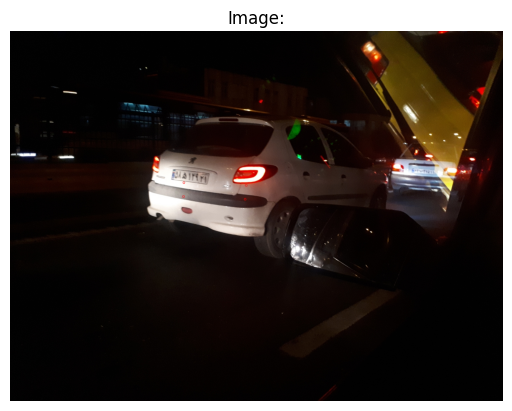

In [64]:
import matplotlib.pyplot as plt

def show_image_with_points(input_image, input_points):
    for i in range(4):
        cv2.circle(input_image, (int(input_points[i, 0]), int(input_points[i, 1])), 3, (0, 0, 255))

    # Display the image using matplotlib
    image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.title('Image:')
    plt.axis('off')  # Hide axes
    plt.show()

def test_model_prediction(num):
    # indicate test image
    test_image_path = os.path.join(main_data_folder, test_images[num])
    test_image = cv2.imread(test_image_path)

    predicted_coordinates = corners(test_image)
    label_coordinates = get_annotations(test_image_path, test_image)
    return test_image, predicted_coordinates, label_coordinates

t_image, predicted_points, label_points = test_model_prediction(2)
print('predicted coordinates: \n', predicted_points)
print('true coordinate: \n', label_points)

show_image_with_points(t_image, predicted_points)

In [65]:
from sklearn.metrics import mean_squared_error

# main of evaluate file in doc
all_predicted = []
all_labels = []
for num in range(len(test_images)):
    test_image, predicted_coordinates, label_coordinates = test_model_prediction(num)
    all_labels.append(label_coordinates)
    all_predicted.append(predicted_coordinates)

# Flatten the arrays
pred_flat = np.array(all_predicted).flatten()
true_flat = np.array(all_labels).flatten()

# Calculate MSE
mse = mean_squared_error(true_flat, pred_flat)

# Print the result
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1382.3079833984375


# **Phase 4 : Classification CNN to extract license plate digits and charachters**

# phase 4 - part 1: import data and perform augmentation

In [66]:
# import os
# print(os.getcwd())

In [67]:
# ! git clone https://github.com/kntu-utils/license-plate-generator.git

In [68]:
# ! pip install jsonnet-binary

In [69]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Reshape, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Lambda
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
import numpy as np
import os
import cv2
import random
import PIL
import matplotlib.pyplot as pl

In [70]:
# ! pip3 install --upgrade -r "/kaggle/working/license-plate-generator/requirements.txt"

In [71]:
# %cd "/kaggle/working/license-plate-generator"

In [72]:
# ! python3 main.py --count 7000 --no-fill --no-transform

**Augmentation**

In [73]:
import random
import numpy as np
import os
import cv2

In [74]:
original_plates_folder = '/kaggle/working/license-plate-generator/output/00/imgs'
original_plates_classes_folder = '/kaggle/working/license-plate-generator/output/00/anns/xmls'

main_folder = '/kaggle/working/'
original_plates = [os.path.join('license-plate-generator/output/00/imgs', f) for f in os.listdir(original_plates_folder) if f.endswith('.jpg')]
print(len(original_plates))

6000


In [75]:
import random
def augment(image: np.ndarray) -> np.ndarray:
    unique_numbers = np.random.choice(range(1, 5 + 1), 5, replace=False)
    for operation in unique_numbers:
        match operation:
            case 1:
                # slight shifts
                tx = random.randint(-13, 10)
                ty = random.randint(-13, 10)
                matrix = np.array([[1, 0, tx],
                                  [0, 1, ty]], dtype=np.float32)

                output_size = (image.shape[1], image.shape[0])
                image = cv2.warpAffine(image, matrix, output_size)

            case 2:
                # contrast adjustments
                adjusted_image = image * random.uniform(0.6, 1.8)
                adjusted_image[adjusted_image > 255] = 255
                image = adjusted_image.astype(np.uint8)

            case 3:
                # blur
                image = cv2.blur(image, (13, 13))

            case 4:
                # rotation
                center = np.array([[image.shape[1] / 2.0], [image.shape[0] / 2.0]])
                th = random.randint(-8, 8) * np.pi / 180  # convert to radians
                rotation_mat = np.array([[np.cos(th), -np.sin(th)],
                                          [np.sin(th), np.cos(th)]], dtype=np.float32)

                translation = np.array(center - np.dot(rotation_mat, center), dtype=np.float32)

                # concatenate rotation_mat and translation to create
                trans_mat = np.array(np.hstack([rotation_mat, translation]), dtype=np.float32)
                image = cv2.warpAffine(image, trans_mat, (image.shape[1], image.shape[0]))
            case 5:
                # re-scale images
                scale = random.uniform(0.75, 1.05)

                matrix = np.array([[scale, 0, 0],
                                  [0, scale, 0]], dtype=np.float32)

                output_size = (image.shape[1], image.shape[0])
                image = cv2.warpAffine(image, matrix, output_size, borderMode=cv2.BORDER_REPLICATE)

    return image

In [76]:
import matplotlib.pyplot as plt

def show_plate_with_lines(input_image, input_points):
    input_image = input_image.copy()
    for i in range(9):

        px_min = int((input_points[i, 1] - input_points[i, 3] / 2)*input_image.shape[0])
        px_max = int((input_points[i, 1] + input_points[i, 3] / 2)*input_image.shape[0])
        py_min = int((input_points[i, 2] - input_points[i, 4] / 2)*input_image.shape[1])
        py_max = int((input_points[i, 2] + input_points[i, 4] / 2)*input_image.shape[1])

        # print(px_min, px_max, px_max, py_max)
        cv2.line(input_image, (px_min, py_min), (px_max, py_min), (0, 255, 255), 2)
        cv2.line(input_image, (px_max, py_min), (px_max, py_max), (0, 255, 255), 2)
        cv2.line(input_image, (px_max, py_max), (px_min, py_max), (0, 255, 255), 2)
        cv2.line(input_image, (px_min, py_min), (px_min, py_max), (0, 255, 255), 2)

    # Display the image using matplotlib
    image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.title('Image:')
    plt.axis('off')  # Hide axes
    plt.show()

**test augmentation on one image**

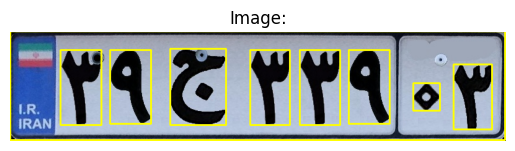

(176, 800, 3)


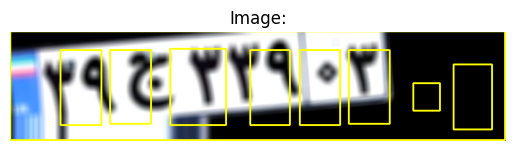

In [77]:
augment_plates = []
augment_classes = []

i = 24
t = original_plates[i]
annotation_path = os.path.join(main_folder, t.replace('imgs', 'anns/xmls').replace('.jpg', '.txt'))
annotations = []
with open(annotation_path, 'r') as file_in:
    for line in file_in:
        annotations.append( list(map(float, line.strip().split(' '))))

annotations = np.array(annotations)

x = os.path.join(main_folder, t)
image = cv2.imread(x)
show_plate_with_lines(image, annotations)
print(image.shape)
new_im = augment(np.array(image))
new_ann = annotations
show_plate_with_lines(new_im, annotations)

In [78]:
# !rm -rf /kaggle/working/augment_plates/xmls/*
# !rm -rf /kaggle/working/augment_plates/imgs/*

**generate 6000 images after augmentation**

uncomment if you want to run

In [79]:
# augment_plates = []
# augment_classes = []

# for i in range(len(original_plates)-1):
#         t = original_plates[i]
#         annotation_path = os.path.join(main_folder, t.replace('imgs', 'anns/xmls').replace('.jpg', '.txt'))
#         annotations = []
#         with open(annotation_path, 'r') as file_in:
#             # write new classes
#             new_ann_path = annotation_path.replace('license-plate-generator/output/00/anns', 'augment_plates').replace('.txt', '_' + str(i) + '.txt')
#             # print('new_ann_path', new_ann_path)
#             with open(os.path.join(main_folder, new_ann_path), 'w') as file:
#                 count = 0
#                 for line in file_in:
#                     annotations.append( list(map(float, line.strip().split(' '))))
#                     count += 1
#                     file.write(line)
#                 if count < 8:
#                     print(new_ann_path)

#         annotations = np.array(annotations)
#         # print(annotations)
#         x = os.path.join(main_folder, t)
#         image = cv2.imread(x)

#         new_im = image
#         if random.random() < 0.99:
#             new_im = augment(image)

#         new_ann = annotations

#         # write new image
#         image_path = t.replace('license-plate-generator/output/00', 'augment_plates').replace('.jpg', '_' + str(i) + '.jpg')
#         augment_plates.append(image_path)
#         cv2.imwrite(os.path.join(main_folder, image_path), new_im)

In [80]:
augment_plates_folder = '/kaggle/working/augment_plates/imgs'
augment_plates_classes = '/kaggle/working/augment_plates/xmls'

augment_images = [os.path.join('augment_plates/imgs/', f) for f in os.listdir(augment_plates_folder) if f.endswith('.jpg')]
print(len(augment_images))

5999


# **phase 4 -  part 2 & 3 : Train and test classification model**

In [81]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Reshape, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Lambda
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
import numpy as np
import os
import cv2
import random
import PIL
import matplotlib.pyplot as pl

In [83]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# print(gpus)
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

In [84]:
augment_plates_folder = '/kaggle/working/augment_plates/imgs'
augment_plates_classes = '/kaggle/working/augment_plates/xmls'
main_folder = '/kaggle/working/'

augment_plates = [os.path.join('augment_plates/imgs/', f) for f in os.listdir(augment_plates_folder) if f.endswith('.jpg')]

***custom data generator to read data***

In [85]:
class CarPlateDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, folder, image_size, batch_size=32, shuffle=True):
        self.folder = folder
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.image_files = images
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_files = [self.image_files[i] for i in indices]
        X, Y = self.__data_generation(batch_files)
        return X, Y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_files))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_files):
        X = np.empty((self.batch_size, self.image_size[0], self.image_size[1], 3), dtype=np.float32)
        Y = {}
        for i in range(8):
            if i != 2:
                Y['class_out_' + str(i)] = np.zeros((self.batch_size, 10), dtype=np.uint8)
            else:
                Y['class_out_' + str(i)] = np.zeros((self.batch_size, 32), dtype=np.uint8)

            

        for i, file in enumerate(batch_files):
            # Load image
            image_path = os.path.join(self.folder, file)
            image = cv2.imread(image_path)

            image = image / 255.0  # Normalize to [0, 1]

            # Load annotations except for last line
            annotation_path =  file.replace('imgs', 'xmls').replace('.jpg', '.txt')
            all_annotations = []

            with open(os.path.join(self.folder, annotation_path), 'r') as f:
                for count, line in enumerate(f):
                    if count != 8:
                        all_annotations.append(list(map(float, line.strip().split(' '))))

            all_annotations = np.array(all_annotations)
            # Sort annotations by x-center
            sorted_annotations = all_annotations[np.argsort(all_annotations[:, 1])]

            # define 1 element of batch
            X[i,] = image
            for j in range(8):
                if j != 2:
                    Y['class_out_' + str(j)][i,sorted_annotations[j, 0].astype(np.uint8)] = 1
                else:
                    Y['class_out_' + str(j)][i,sorted_annotations[j, 0].astype(np.uint8)-10] = 1

        return X, Y

***Define model***

In [86]:
test = cv2.imread(os.path.join(main_folder, augment_plates[0]))
plate_batch_size = 64
image_size = (test.shape[0], test.shape[1])   # (176, 800, 3)
print('image size: ', *image_size)
# Split into train , validate and test sets
train_images, test_vall_images = train_test_split(augment_plates, test_size=0.3, random_state=42)
vall_images, test_images = train_test_split(test_vall_images, test_size=0.5, random_state=42)

plate_train_generator = CarPlateDataGenerator(train_images, main_folder, image_size=image_size, batch_size=plate_batch_size)
plate_val_generator = CarPlateDataGenerator(vall_images, main_folder, image_size=image_size, batch_size=plate_batch_size)
plate_test_generator = CarPlateDataGenerator(test_images, main_folder, image_size=image_size, batch_size=plate_batch_size, shuffle=False)

image size:  176 800


In [87]:
inputs = Input(shape=(*image_size, 3))

x = Conv2D(32, (5, 5), padding='same')(inputs)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)   # pooling

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)   # pooling

x = Conv2D(128, (3, 3))(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)   # pooling

x = Conv2D(128, (3, 3))(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)   # pooling

x = Conv2D(128, (3, 3))(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = Conv2D(256, (1, 1))(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = Conv2D(128, (3, 3))(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)   # pooling

x = Conv2D(256, (3, 3))(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)   # pooling

# get 256 number of 1*8 feature maps
x = Flatten()(x)
x = Dense(2048, name='all_features')(x)
feature_maps = Reshape((256, 8), name='get_feature_maps')(x)

# Split and concatenate into 8 tensors of shape (256,)
feature_maps = [Lambda(lambda t: t[:, :, i])(feature_maps) for i in range(8)]

concatenated_maps = Concatenate(axis=1, name='concate_vertically')(feature_maps)
concatenated_maps = Reshape((8, 256), name='convert_feature_maps')(concatenated_maps)

# temp_model = Model(inputs=inputs, outputs=concatenated_maps)
# temp_model.summary()


# Fully connected layers to classify each element
outputs = []
for i in range(8):
    digit_class = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='FDense_' + str(i))(concatenated_maps[:, :, i])
    digit_class = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='SDense_' + str(i))(digit_class)
    
    if i != 2:
        digit_class = Dense(10, activation='softmax', name='class_out_' + str(i))(digit_class)
    else:
        digit_class = Dense(32, activation='softmax', name='class_out_' + str(i))(digit_class)
    outputs.append(digit_class)

plate_model = Model(inputs=inputs, outputs=outputs)

losses = {}
metrics={}
loss_weights={}

for i in range(8):
    losses['class_out_' + str(i)] = 'categorical_crossentropy'
    metrics['class_out_' + str(i)] = ['accuracy']
    if i != 2:
        loss_weights['class_out_' + str(i)] = 1.0
    else:
        loss_weights['class_out_' + str(i)] = 3.0

plate_model.compile(optimizer='adam',
              loss=losses,
              metrics=metrics,
              loss_weights=loss_weights)

plate_model.summary()

Model: "functional_66"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 176, 800,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 176, 800,  │      2,432 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 176, 800,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 176, 800,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 88, 400,   │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 88, 400,   │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 88, 400,   │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 88, 400,   │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 44, 200,   │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 42, 198,   │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 42, 198,   │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 42, 198,   │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 21, 99,    │          0 │ re_lu_2[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 19, 97,    │    147,584 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 97,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 19, 97,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 10, 49,    │          0 │ re_lu_3[0][0]   

 Total params: 6,868,774 (26.20 MB)

 Trainable params: 6,866,534 (26.19 MB)

 Non-trainable params: 2,240 (8.75 KB)

In [88]:
tf.keras.backend.clear_session()

# Train the model (try epoch 20)
history = plate_model.fit(plate_train_generator, epochs=1, validation_data=plate_val_generator, batch_size=plate_batch_size)
print(history)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-07-23 19:30:09.353748: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,88,400]{3,2,1,0}, f32[64,64,88,400]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-23 19:30:10.067095: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.713499623s
Trying algorithm eng0{} for conv (f32[64,32,

 1/65 ━━━━━━━━━━━━━━━━━━━━ 46:52 44s/step - class_out_0_accuracy: 0.0781 - class_out_1_accuracy: 0.1406 - class_out_2_accuracy: 0.0469 - class_out_3_accuracy: 0.1719 - class_out_4_accuracy: 0.1250 - class_out_5_accuracy: 0.0625 - class_out_6_accuracy: 0.0938 - class_out_7_accuracy: 0.1094 - loss: 27.4547

W0000 00:00:1721763024.378984     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


65/65 ━━━━━━━━━━━━━━━━━━━━ 68s 378ms/step - class_out_0_accuracy: 0.1049 - class_out_1_accuracy: 0.1171 - class_out_2_accuracy: 0.0356 - class_out_3_accuracy: 0.1039 - class_out_4_accuracy: 0.1102 - class_out_5_accuracy: 0.1054 - class_out_6_accuracy: 0.1043 - class_out_7_accuracy: 0.0980 - loss: 26.9907 - val_class_out_0_accuracy: 0.1105 - val_class_out_1_accuracy: 0.1060 - val_class_out_2_accuracy: 0.0636 - val_class_out_3_accuracy: 0.1172 - val_class_out_4_accuracy: 0.1049 - val_class_out_5_accuracy: 0.1295 - val_class_out_6_accuracy: 0.0949 - val_class_out_7_accuracy: 0.1004 - val_loss: 26.5001


In [89]:
plate_model.evaluate(plate_test_generator)

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 256ms/step - class_out_0_accuracy: 0.1296 - class_out_1_accuracy: 0.1041 - class_out_2_accuracy: 0.0707 - class_out_3_accuracy: 0.0962 - class_out_4_accuracy: 0.1221 - class_out_5_accuracy: 0.1166 - class_out_6_accuracy: 0.1155 - class_out_7_accuracy: 0.1043 - loss: 26.5038


[26.498027801513672,
 0.1227678582072258,
 0.1104910746216774,
 0.0703125,
 0.1004464253783226,
 0.1216517835855484,
 0.1227678582072258,
 0.109375,
 0.0904017835855484]

**save model phase 4**

In [90]:
# # !rm -rf /kaggle/working/plate_models/*
# import os
# os.remove("/kaggle/working/plate_models.h5")

In [91]:
# # Create a directory if it is not there, so we can save files and results in it
from pathlib import Path
Path('/kaggle/working/plate_models/model_5').mkdir(parents=True, exist_ok=True)

In [92]:
model_path = '/kaggle/working/plate_models/model_5/p.keras'
plate_model.save(model_path)

# **Phase 4 - part 4**

In [93]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
import numpy as np
import os
import cv2
import random
import PIL
import matplotlib.pyplot as pl

In [94]:
# to enable kaggle to read model from output directory
keras.config.enable_unsafe_deserialization()
load_path = '/kaggle/working/plate_models/model_3/p.keras'
plate_model = keras.models.load_model(load_path)

photo_model_path = '/kaggle/working/photo_models/model_10/m.keras'
photo_model = keras.models.load_model(photo_model_path)

In [95]:
test_accuracy = plate_model.evaluate(plate_test_generator)

14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 232ms/step - class_out_0_accuracy: 0.9813 - class_out_1_accuracy: 0.9847 - class_out_2_accuracy: 0.4596 - class_out_3_accuracy: 0.8791 - class_out_4_accuracy: 0.8414 - class_out_5_accuracy: 0.8350 - class_out_6_accuracy: 0.8256 - class_out_7_accuracy: 0.7801 - loss: 9.9678


# Test only model phase 4 (classification)

In [96]:
def extract(image: np.ndarray, points: np.ndarray) -> np.ndarray:
    # reshape points
    points = points.reshape(4, 2).tolist()
    points = [[point[0] * image.shape[1], point[1] * image.shape[0]] for point in points]
    points = np.array(points, dtype=np.float32)

    # compute height and with of plate based on height
    height = 176
    width = 800

    # desired size of plate (point are 4 corners)
    points2 = np.array([[0, 0],
                        [width, 0],
                        [width, height],
                        [0, height]]).astype(np.float32)

    # homography to convert plate to corresponding desired size
    homography = cv2.getPerspectiveTransform(points, points2)
    output_size = (width, height)
    warp = cv2.warpPerspective(image, homography, output_size)

    return warp

In [97]:
import matplotlib.pyplot as plt

def show_image(input_image):
    image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.title('Image:')
    plt.axis('off')  
    plt.show()

original_image_folder = '/kaggle/working/data/original/images/'
original_annotation_folder = '/kaggle/working/data/original/labels/'
augment_image_folder = '/kaggle/working/data/augment/images/'
augment_annotation_folder = '/kaggle/working/data/augment/labels/'
main_data_folder = '/kaggle/working/'

original_images = ['data/original/images/'+ f for f in os.listdir(original_image_folder) if f.endswith('.jpg')]
augment_images = ['data/augment/images/'+ f for f in os.listdir(augment_image_folder) if f.endswith('.jpg')]
print("length of augment images",len(augment_images))
all_images = original_images + augment_images
print("length of all images", len(all_images))

length of augment images 4000
length of all images 5883


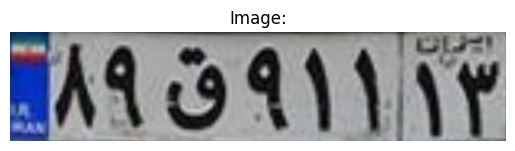

license plate:
8 9 V 9 1 1 0 3


W0000 00:00:1721763068.103017     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [98]:
def read_plate(image: np.ndarray) -> str:
    X = np.zeros((plate_batch_size, image.shape[0], image.shape[1], 3), dtype=np.float32)
    image = image / 255.0
    X[0,] = image
    softmax_outputs = plate_model.predict(X, verbose=0)
    
    with open('/kaggle/working/license-plate-generator/classes.txt', 'r') as f:
        all_digits = []
        for count, line in enumerate(f):
            all_digits.append(line.replace('\n', ''))
    
    # Convert softmax probabilities to predicted class indices
    predicted_digits = []
    for i in range(8):
        if i != 2:
            predicted_digits.append(np.argmax(softmax_outputs[i][0], axis=0))
        else:
            predicted_digits.append(np.argmax(softmax_outputs[i][0], axis=0)+ 10)
        
    
    
    output_str = [all_digits[digit] for digit in predicted_digits]
    return str(' '.join(output_str))



# test funstion
# Read and show main image
test_image_path = os.path.join(main_data_folder, original_images[1])
test_image = cv2.imread(test_image_path)
# show_image(test_image)

# Load corners
image_corners = []
annotation_path = test_image_path.replace('images', 'labels').replace('.jpg', '.txt')
with open(annotation_path, 'r') as f:
    image_corners = list(map(float, f.read().strip().split(' ')))
    image_corners.pop(0)

plate_image = extract(test_image, np.array(image_corners))
show_image(plate_image)
plate_string = read_plate(plate_image)
print('license plate:\n', plate_string, sep='')

# Test combined with model phase 3 and 4:

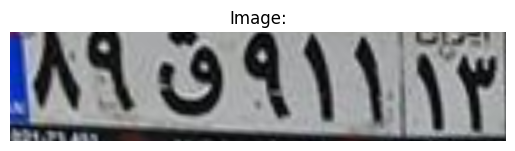

6 9 Q 9 1 1 1 3


In [99]:
def corners(image: np.ndarray, batch_size=32) -> np.ndarray:
    test_input = np.full((batch_size, 256, 256, 3), None, dtype=np.float32)
    test_image = cv2.resize(image, (256, 256))
    test_image = test_image / 255.0  # Normalize to [0, 1]
    test_input[0,] = test_image

    predicted_coordinates = photo_model.predict(test_input, verbose=0)[0]
    return np.array(predicted_coordinates, dtype=np.float32)

def read_single(image: np.ndarray) -> str:
    image_corners = corners(image)
#     show_image(image)
    plate_image = extract(image, image_corners)
    show_image(plate_image)
    plate_string = read_plate(plate_image)
    
    return plate_string


# test combined
test_image_path = os.path.join(main_data_folder, original_images[1])
test_image = cv2.imread(test_image_path)
plate_numbers = read_single(test_image)
print(plate_numbers)

In [100]:
!pip install ultralytics

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


/kaggle/working/multiple-cars/day_06184.jpg

0: 320x640 2 cars, 104.3ms
Speed: 1.6ms preprocess, 104.3ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 640)


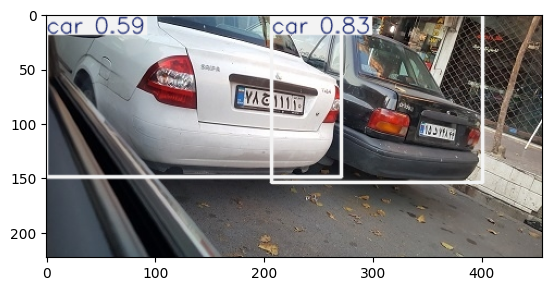

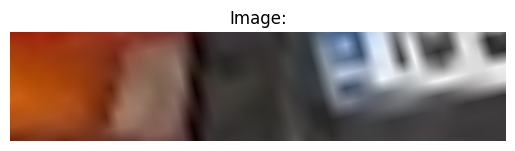

1 1 SAD 1 2 7 0 0


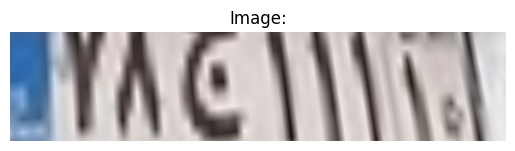

7 6 HE 1 1 1 1 0


In [104]:
from ultralytics import YOLO

# load model
trained_yolo = YOLO("yolov8n.pt")

def read_multiple(image: np.ndarray) -> list[tuple[np.ndarray, str]]:
    results = trained_yolo(image)[0]  # return a list of Results objects
    
    # show predicted image with objects
    im_array = results.plot()
    plt.imshow(PIL.Image.fromarray(im_array[..., ::-1]))
    plt.show()
    
    for i in range(len(results.boxes.cls)):
        if results.boxes.cls[i] == 2:  # loop through car objects
            car_coordinate = list(results.boxes.xyxy[i])
            x_min, y_min, x_max, y_max = [t.item() for t in car_coordinate]
            car_width = x_max - x_min
            car_height = y_max - y_min
            
            # extract car image
            car_image = image[int(y_min):int(y_max),int(x_min):int(x_max),:]
            print(read_single(car_image))

    
# test read_multiple funstion
mupltiple_cars = [os.path.join('/kaggle/working/multiple-cars/', f) for f in os.listdir('/kaggle/working/multiple-cars') if f.endswith('.jpg')]
test_image_path = mupltiple_cars[5]
print(test_image_path)
test_image = cv2.imread(test_image_path)
read_multiple(test_image)